In [1]:
import pandas
import numpy as np
import sklearn

In [2]:
import scipy.misc as misc
filename = 'san_sebastian.jpg'
img = misc.imread(filename)

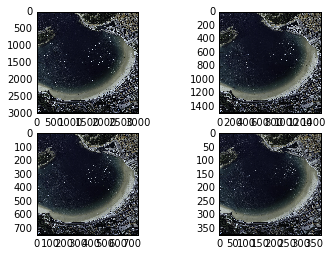

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.subplot(2,2,1)
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(img[::2,::2])
plt.subplot(2,2,3)
plt.imshow(img[::4,::4])
plt.subplot(2,2,4)
plt.imshow(img[::8,::8])

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[:,:,:3], [0.299, 0.587, 0.114])
def gray2rgb(gray):
    r = gray * 1/.299
    g = gray * 1/.587
    b = gray * 1/.114
    #rgb = np.array((r.shape,3))
    #print(rgb.shape)
    #rgb[:,:,0] = r
    #rgb[:,:,1] = g
    #rgb[:,:,2] = b
    rgb = np.array([r,g,b])
    rgb = np.transpose(rgb,(1,2,0))
    print(rgb.shape)
    return rgb

In [5]:
#rgb = gray2rgb(labels)
#print(rgb.shape)
#print(labels.shape)
d = np.array((labels.shape[0],labels.shape[1],3))
d = np.array([labels,labels,labels])
labels.shape
#print(d.shape[0],d.shape[1],d.shape[2])
print(d.shape)

NameError: name 'labels' is not defined

In [6]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#X = rgb2gray(img)
s_rate = 10 # sampling_rate
rows,cols,bands = img.shape
X = img[::s_rate,::s_rate].reshape((-1,3))
# Compute DBSCAN
db = DBSCAN(eps=.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

#print('Estimated number of clusters: %d' % n_clusters_)
#print("Silhouette Coefficient: %0.3f"
  #    % metrics.silhouette_score(X, labels))

## Label map

C:\Users\adam_fa\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


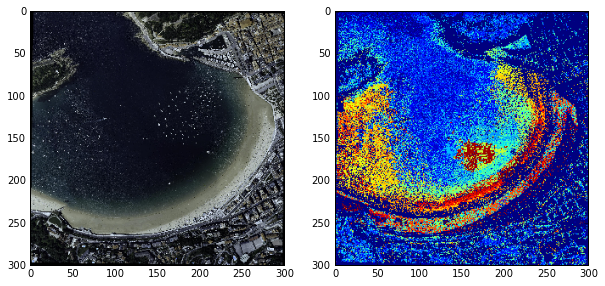

In [7]:
labels = labels.reshape((rows/s_rate,cols/s_rate))
plt.figure(figsize = (10,20))
plt.subplot(1,2,1)
plt.imshow(img[::10,::10])
plt.subplot(1,2,2)
plt.imshow(labels)

In [66]:
#misc.imsave('label_map.jpg',gray2rgb(labels))
rgb = np.array([labels*.5,labels*.5,labels*.9]).transpose((1,2,0))
print(rgb.shape)
misc.imsave('rgb.jpg',rgb)

(300, 300, 3)


# Feature extraction

In [8]:

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage.filters import gabor_kernel

In [39]:
def filter_image(image, kernels):
    filtered = []
    for k, kernel in enumerate(kernels):  
        # filtered.append(ndi.convolve(image, kernel, mode='wrap'))
        kernel = np.array([kernel,kernel,kernel]).transpose((1,2,0))
        img = ndimage.convolve(image, kernel, mode='wrap')
        print('type of img')
        print(type(img))
        print(img[0,0,0])
        filtered.append(img[::8,::8]) # take a down-sampled version of the filtered one
    return filtered

In [44]:
kernels = []
#for theta in range(4):
for theta in [0,45,90,135]:# different angles in the bank
   for sigma in [.5,1,3]:
        #sigma = .5
        for frequency in (.5,1,3, 5):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

In [ ]:
# put the filtered images in one array X
data = []
#X = np.array(105)
for i,rgb_img in enumerate(img_list):
    filtered = filter_image(rgb2gray(rgb_img[::2,::2]),kernels)
    img_arr = np.concatenate(np.array(filtered))
    data.append(img_arr.flatten())
    #data.append(np.reshape(img_arr,(1,524288)))
    #for j,fil_img in enumerate(filtered):
        #misc.imsave(str(i)+'_'+str(j)+'.png',fil_img)
X = np.array(data)


In [ ]:
# is simply the classes we have
y = []
for i in range(21):
    y += 5 * [i]
y = np.array(y)
X[0].shape


In [51]:
from scipy import ndimage
g = gabor_kernel(frequency, theta=theta,sigma_x=sigma, sigma_y=sigma)
#print(g.shape)
g[0,0]
k = np.array(3*[g]).transpose((1,2,0))
#k = np.transpose(k,(1,2,0))
print(k.shape)
img_sub = img[::10,::10]
#print(img_sub.shape)
img_g = ndimage.convolve(img_sub, k, mode='wrap')
#print(img_g.shape)
print(type(img_g))
img_g[0,0,]

(19, 19, 3)


C:\Users\adam_fa\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<class 'numpy.ndarray'>


0

In [59]:
#img_g[120:130,120:130,:]

In [50]:
#for k,kernel in enumerate(kernels):
    #print(kernel.shape)

In [46]:
img_g.shape

(300, 300, 3)

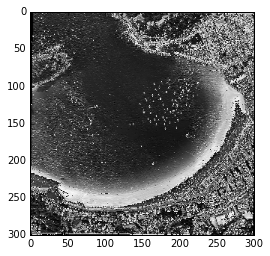

In [47]:
plt.imshow(img_g)

In [48]:
img.shape

(3000, 3000, 3)

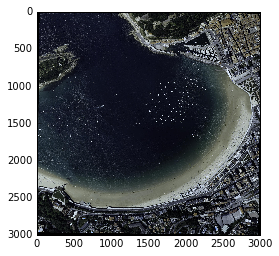

In [49]:
plt.imshow(img)